# Time Log App
<img src='https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTBepozD0DfuxWa5mS21jkqMOzrlAdwegiBnw&usqp=CAU'>

>A google colab notebook, that collects time logged in and logged out with a press of a button.  




In [ ]:
#@title Log Time { vertical-output: true }
import pandas as pd
import datetime as dt
import pytz
import csv

current_time = dt.datetime.now(pytz.timezone('America/New_York'))
ctime = current_time.strftime("%Y-%m-%d, %a, %H:%M")
path = '/content/drive/MyDrive/Mandarin_Folder/hours/'


def write_time(in_out,w_or_a):
    
    if in_out == 'time in':
        file = 'timein.csv'
    else: 
        file = 'timeout.csv'
    
    if w_or_a == 'new':
        with open(path + file, 'w') as time_file:
            writer = csv.writer(time_file)
            writer.writerow([log_type])
            writer.writerow([ctime])
            print(in_out.upper(),'-->',current_time.strftime('%-I:%M %p')," | ", 
              current_time.strftime('%a'), current_time.strftime('%-m/%-d/%y'), '\n')
    else:
        with open(path + file, 'a') as time_file:
            writer = csv.writer(time_file)
            writer.writerow([ctime])
            print(in_out.upper(),'-->',current_time.strftime('%-I:%M %p')," | ", 
              current_time.strftime('%a'), current_time.strftime('%-m/%-d/%y'),'\n')

def readlogs(filename):
    df = pd.read_csv(path + filename)
    return(len(df))

def return_records():
    timein = readlogs('timein.csv')
    timeout = readlogs('timeout.csv')
    return print("\nNo. of Records:\nlog in:", timein, "\nlog out:", timeout)

def messages():
    timein = readlogs('timein.csv')
    timeout = readlogs('timeout.csv')
    if timein == timeout:
        print('\nAll good, Great job!')
    elif timein < timeout: 
        print('Undo last log out!')
    elif timein > timeout+1:
        print('Undo Last Log in!')
    elif timein > timeout-1:    
        print('Don\'t forget to log out!')  

log_type = "time out" #@param ["time in", "time out"]
new_or_append = "append" #@param ["append"]

write_time(log_type, new_or_append)
messages()
return_records()


In [ ]:
#@title View DataFrame
import pandas as pd

path = '/content/drive/MyDrive/Mandarin_Folder/hours/'

def csv_to_pandas(file):
    
    def fix_time(time):
        return(time.strftime('%-I:%M %p'))
    def return_day(time):
        return(time.strftime('%a'))    
    def return_date(time):
        return(time.strftime('%-m/%-d/%y')) 

    df = pd.read_csv(file)
    df.iloc[:,0] = pd.to_datetime(df.iloc[:,0])
    df.drop_duplicates(inplace=True)
    
    df['date'] = df.iloc[:,0].apply(return_date)
    df['day'] = df.iloc[:,0].apply(return_day)
    df['time'] = df.iloc[:,0].apply(fix_time)
    df = df.iloc[:,1:]
    return df

def main():
    main = pd.concat([csv_to_pandas(path+'timein.csv'), csv_to_pandas(path+'timeout.csv')], axis=1)
    main.columns = ['A','B','C','D','E','F']
    main = main.drop(['D','E'], axis = 1)
    main.columns = ['date', 'day', 'time_in', 'time_out']
    main['duration'] = main.time_out.astype('datetime64[ns]') - main.time_in.astype('datetime64[ns]')
    main['duration'] = main.duration.astype(str).map(lambda x: x[7:])
    return main

main()   

In [ ]:
#@title Undo last log
def undo(undo_file):
    if undo_file == 'none':
        print('Nothing to undo')
    else:    
        undo_file = undo_file.replace(" ", '') + '.csv'
    
        lines = []
    
        # Parse the file into lines
        with open(path + undo_file, 'r') as f:
            for line in f:
                lines.append(line)

        # Write them back to the file
        with open(path + undo_file, 'w') as f:
            f.writelines(lines[:-1])
            print('Removed: ', lines[-1])
            
undo_log = "none" #@param ["time in", "time out", "none"]
undo(undo_log)
return_records()  
messages()   

In [ ]:
#@title Edit Time

edit_log = "time in" #@param ["time in", "time out"]
file = path + edit_log.replace(" ", '') + '.csv'
edit_df = pd.read_csv(file)

print('Total records', len(edit_df), '| Index of Records from 0 to', len(edit_df)-1,'\n')

def proceed_edit(index_to_edit, edit_time,time_edit):
    
    index_to_edit =  0#@param {type:"number"}
    edit_time = "no" #@param ["yes", "no"]
    time_edit = "2021-10-16, Sat, 07:29" #@param {type:"string"}    
    print('Edit this entry? --->',edit_df.iloc[index_to_edit].values[0])

    if edit_time == 'yes':
        edit_df.iat[index_to_edit,0] = time_edit
        print('\nSUCCESS! Edited to -->', edit_df.iat[index_to_edit,0])
    else:
        print('\nNo edits made')     

    edit_df.to_csv(path + edit_log.replace(" ", '') + '.csv', index=False)

proceed_edit(index_to_edit, edit_time,time_edit)

In [ ]:
#@title View Records
return_records()
print(' ')    
messages()

In [ ]:
#@title Analyze Hours
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

worksheet = gc.open('hours').sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()

# Convert to a DataFrame and render.
import pandas as pd
gsheet = pd.DataFrame.from_records(rows)

new_header = gsheet.iloc[0] #grab the first row for the header
gsheet = gsheet[1:] #take the data less the header row
gsheet.columns = new_header
gsheet = gsheet.iloc[:, :-2]
columns_titles = ["Day","Date","In","Out", "Hours"]
gsheet = gsheet.reindex(columns=columns_titles)
gsheet.columns = ['day','date','time_in','time_out','duration']
gsheet['day'] = gsheet['day'].str.rstrip()

main2 = pd.concat([gsheet, main()], axis=0)
main2['date'] = pd.to_datetime(main2['date'])

time = pd.DatetimeIndex(main2['duration'])
main2['mins'] = time.hour * 60 + time.minute

main2['day_num'] = main2['date'].dt.isocalendar().day
main2['week_num'] = main2['date'].dt.isocalendar().week

In [ ]:
#@title Back up to Excel and CSV { display-mode: "form" }
try:
    import xlsxwriter
    from google.colab import files
except:
    !pip install xlsxwriter
    
writer = pd.ExcelWriter(path+"main_hours.xlsx", engine='xlsxwriter')
main2.to_excel(writer,sheet_name = "timelog.xlsx", index=False)
writer.save() 

main2.to_csv(path + 'main_hours.csv', index=False)

In [ ]:
#@title Total Hours Worked Per Week and Difference of  Rate per Week

# Hours worked per week
mins_per_week = main2.groupby([main2['date'].dt.isocalendar().week]).mins.sum()
hours_per_week = mins_per_week/60

# Weekly rate
rate = open(path+ 'rate.txt','r')
rate = float(rate.read())

weekly_rate = rate
hourly = weekly_rate / 40 
mins_per_week = main2.groupby([main2['date'].dt.isocalendar().week]).mins.sum()
hours_per_week = round(mins_per_week / 60,3)
hourly_rate_per_week = round(weekly_rate / hours_per_week,3) 

# Weekly difference from actual rate 
diff_from_hourly = round(hourly_rate_per_week - hourly,3)

# Overtime rate
overtime_pay = round((hours_per_week - 40) * (hourly * 1.5),3)

hours_df = pd.concat([hours_per_week, hourly_rate_per_week,diff_from_hourly, overtime_pay], axis=1)
hours_df.columns = ['hours_worked','hourly_rate_per_week' ,'diff_from_hourly_rate', 'overtime_pay']

# if overtime is negative return zero
hours_df.loc[(hours_df.overtime_pay < 0), "overtime_pay"] = 0

hours_df.to_csv(path + 'analyses.csv')
hours_df

In [ ]:
#@title Average Hours Worked { run: "auto" }
query_by = "day" #@param ["week_num", "day"]
def avg_hrs(query_by):
    return main2.groupby([query_by]).mins.mean()/60
avg_hrs(query_by)


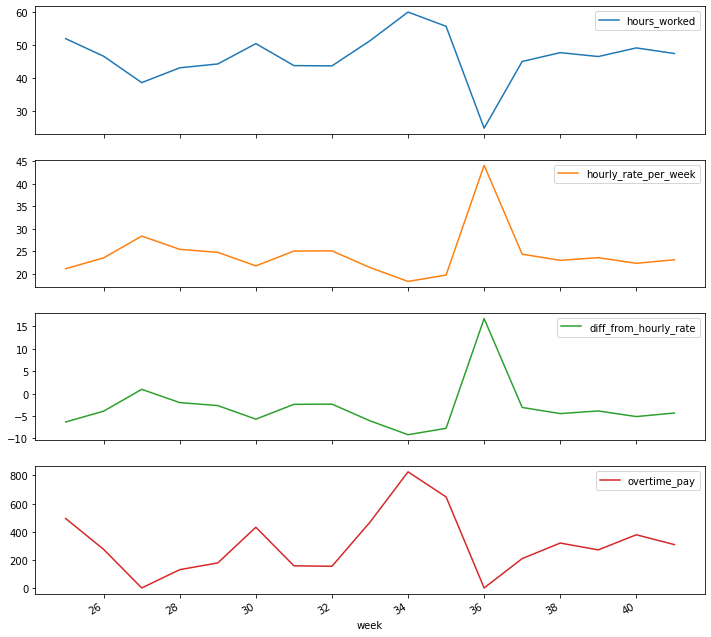

In [ ]:
#@title Visualize
axes = hours_df.plot.line(figsize=(12,12), subplots=True);

In [ ]:
#@title View by Week { run: "auto" }
week_num = "41" #@param {type:"string"}
def mask_week(num):
    return main2.query('week_num == @num')

mask_week(week_num)

,day,date,time_in,time_out,duration,mins,day_num,week_num
84,Mon,2021-10-11,7:30:00 AM,4:51:00 PM,9:21:00,561.0,1,41
85,Tue,2021-10-12,7:30:00 AM,5:40:00 PM,10:10:00,610.0,2,41
86,Wed,2021-10-13,7:30:00 AM,4:30:00 PM,9:00:00,540.0,3,41
87,Thu,2021-10-14,7:30:00 AM,4:33:00 PM,9:03:00,543.0,4,41
88,Fri,2021-10-15,7:30:00 AM,5:26:00 PM,9:56:00,596.0,5,41


In [ ]:
#@title View by Day { run: "auto" }
day_name = "tue" #@param {type:"string"}
def mask_day(day_name):
    day_name = day_name.title()[:3]
    return main2.query('day == @day_name')

mask_day(day_name)